In [2]:
import pandas as pd
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('ZeroClassification.csv')
bucket_name = 'the-peoples-speech-west-europe'
prefix = 'forced-aligner/durations_csv_dump/'
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
iterator = bucket.list_blobs(delimiter='/', prefix=prefix)
response = iterator._get_next_page_response()

from tqdm import tqdm
df_ = pd.DataFrame()
for i in tqdm(range(len(response['items']))):
    name = response['items'][i]['name']
    if name.split('.')[-1] == 'csv':
        df = pd.read_csv('gs://{}/{}'.format(bucket_name, name))
        df_ = pd.concat([df_, df])
df = pd.read_csv('ZeroClassification.csv')
df = df[~df['classification'].isin(['South America', 'North America', "Asia",
                               "Europe", "Australia", 'Africa','Artificial intelligence',
                              'Feed nutrition', 'Elections'])]
df['classification'] = np.where(df['classification'] == 'Financials', 'Finance', df['classification'])
df['classification'] = np.where(df['classification'] == 'Healthy', 'Health', df['classification'])
df = pd.merge(df, df_, on=['text_document_id', 'identifier'])

100%|██████████| 202/202 [04:11<00:00,  1.25s/it]


In [12]:
df.groupby(['classification'], as_index=False).agg({'duration':'sum'}).sort_values(['duration'], ascending=False,
                                                                         ).to_csv('DataClassification.csv', index=False)

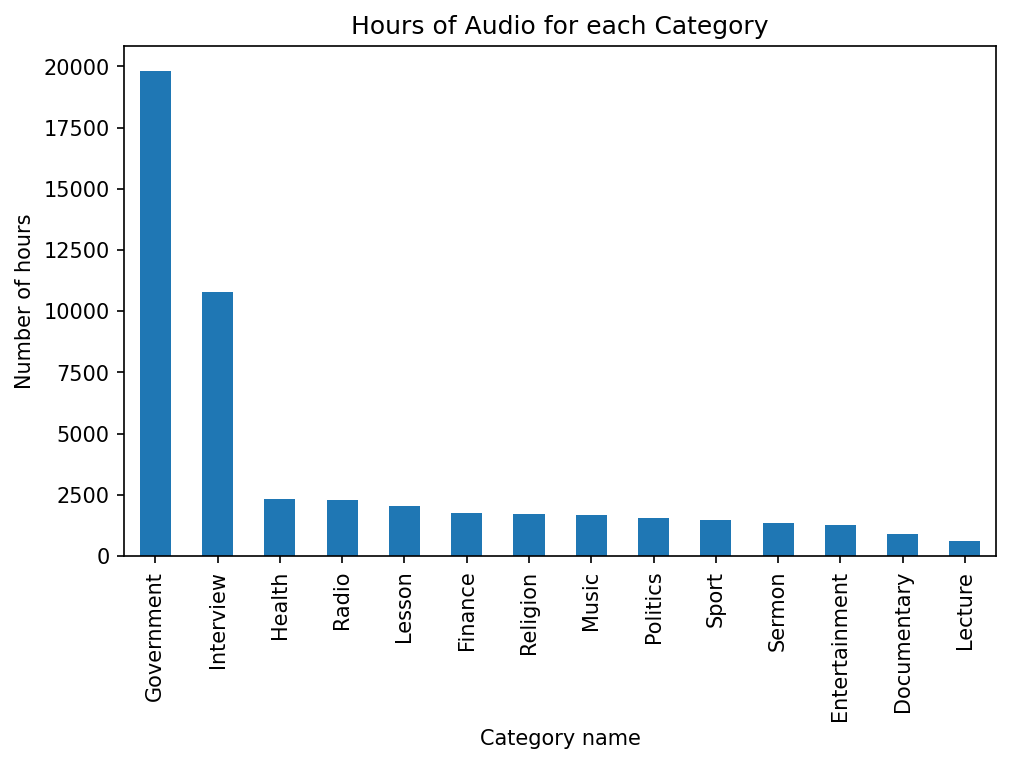

In [7]:
plt.rcParams["figure.dpi"] = 150
test = df.groupby(['classification']).agg({'duration':'sum'}).sort_values(['duration'], ascending=False,
                                                                         )
ax = test.plot.bar(title='Hours of Audio for each Category', figsize=(7.5,4.5))
ax.set_xlabel("Category name")
ax.get_legend().remove()
ax.set_ylabel("Number of hours");

##  NER

### Transcriptions

In [4]:
df = pd.read_csv('transcriptNer.csv')
df['GPE'] = np.where((df['GPE'] == 'the United States') | (df['GPE'] == 'U.S.') | (df['GPE'] == 'United States'),
                     'US', df['GPE'])
df['GPE'] = np.where((df['GPE'] == 'New York City') | (df['GPE'] == 'N.Y.') | (df['GPE'] == 'NY'),
                     'New York', df['GPE'])
df.head()

/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,ten,today,Force twenty seventeen,the I 'm Federal Reserve,Phoenix,English,the Defense of Marriage Act,Pieria,eight thousand nine hundred seventy five dollars,US-mexican,second,Border Patrol,only 0.2 percent,Sam winona,S. One,some eighty miles,five minutes,a Bachelor of Science degree
1,ten,today,nine eleven Conference,the US Naval Academy,Phoenix,German,the Defense of Marriage Act,the New York,about a five hundred thousand dollars,US-mexican,second,Border Patrol,0.2 percent only 0.2 percent,Sam winona,the Deepwater Horizon,some eighty miles,five minutes,a Bachelor of Science degree
2,one,today,World War two,the US Naval Academy,Phoenix,German,the Defense of Marriage Act,Nature Conservancy,5.4 billion 5.4 billion 5.4 billion,US-mexican,second,Border Patrol,47 percent,Sam winona,Deepwater Horizon,some eighty miles,five minutes,Ratings Standard & Poor 's Ratings Standard & ...
3,one,today,Watergate,Metro,Phoenix,Arabic,DOMA,Malka,two hundred seventy billion dollars,Mexican,first,Border Patrol Agent,47 percent,josephine josephine,Deepwater Horizon,10 km,five minutes,I know I A I time magazine piece I know I A I ...
4,one,today,the Day May Day,Jellicoe Manor,Phoenix,Arabic,DOMA,West Maui,seventy billion dollars,Mexican,first,Border Patrol,47 percent,josephine Terry,Deepwater Horizon,10 km,five minutes,Omnibus Budget report on the Omnibus Budget


## LOC

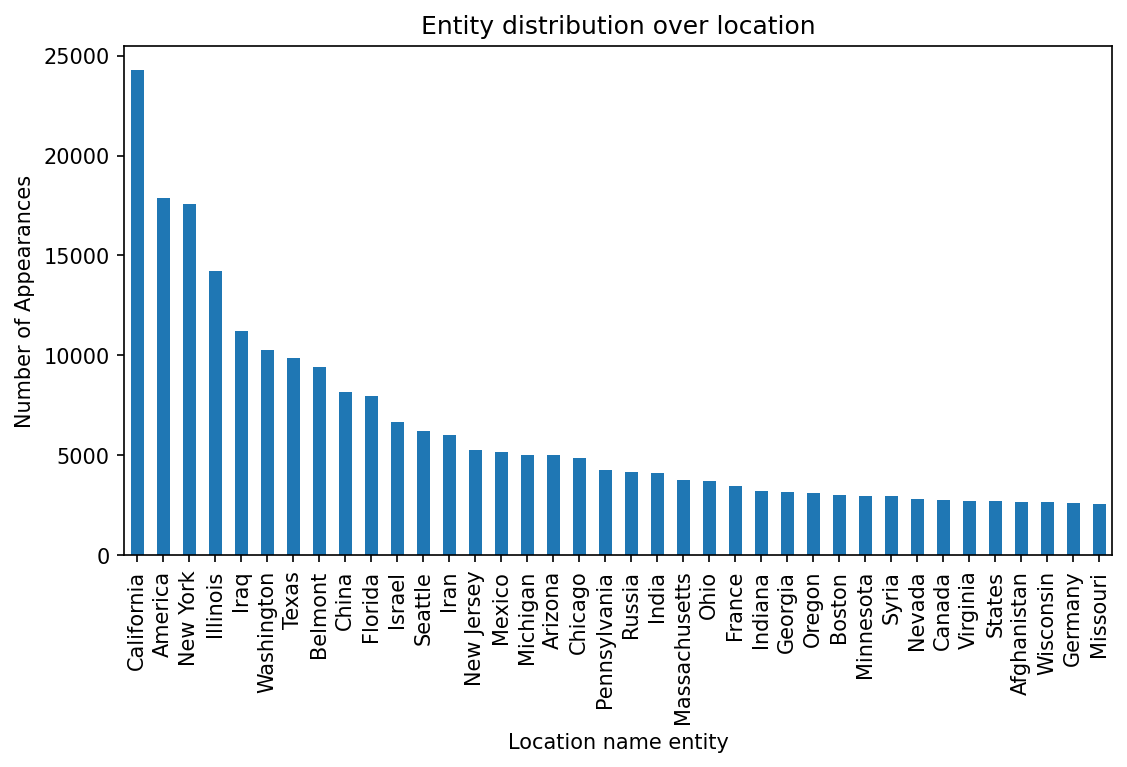

In [5]:
df_ = df[df.groupby('GPE')['GPE'].transform('count') > 2500]
df_ = df_[~df_['GPE'].isin(['US'])]
ax = df_['GPE'].value_counts().plot(kind='bar', title='Entity distribution over location', figsize=(8.5,4.5));
ax.set_xlabel("Location name entity")
ax.set_ylabel("Number of Appearances");

## Language

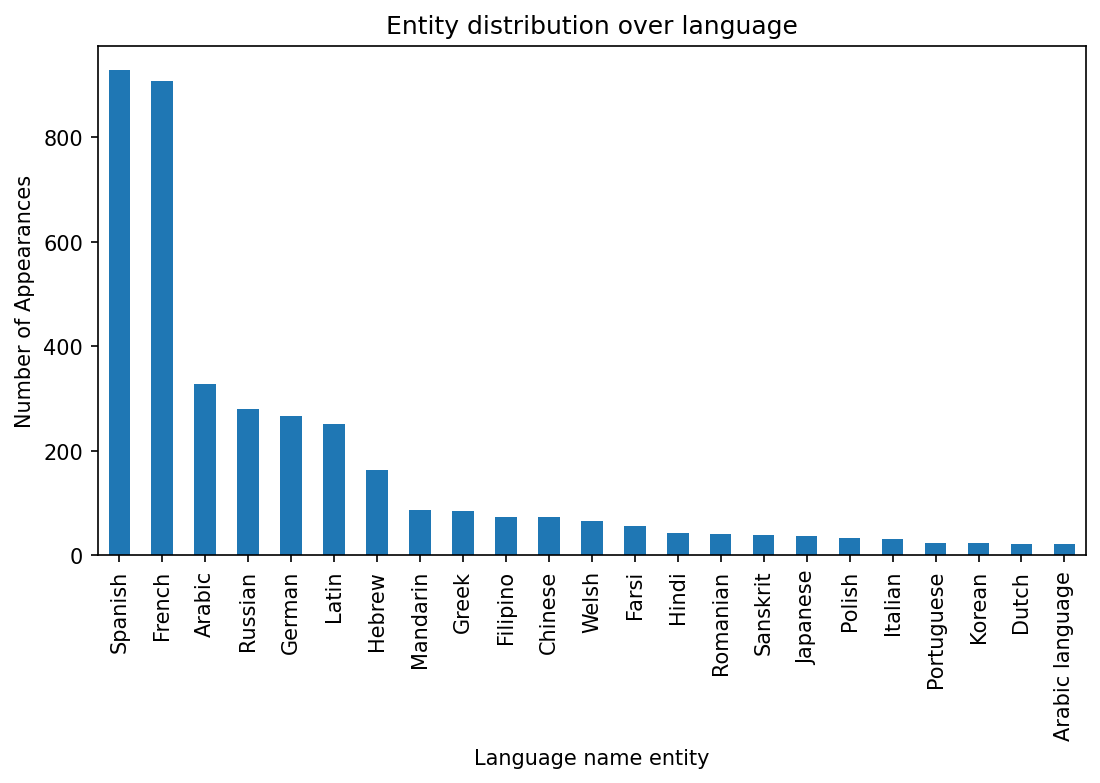

In [6]:
df_ = df[df.groupby('LANGUAGE')['LANGUAGE'].transform('count') > 20]
df_ = df_[~df_['LANGUAGE'].isin(['English'])]
ax = df_['LANGUAGE'].value_counts().plot(kind='bar', title='Entity distribution over language', figsize=(8.5,4.5));
ax.set_xlabel("Language name entity")
ax.set_ylabel("Number of Appearances");

## Affiliation

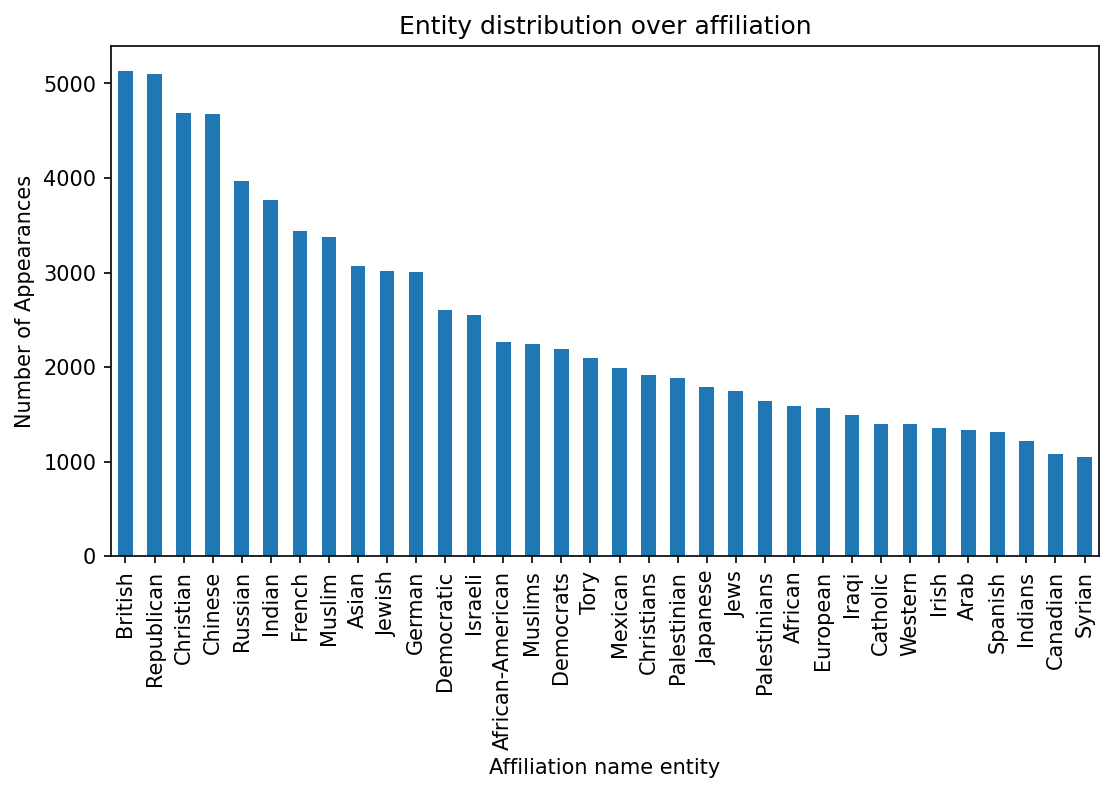

In [7]:
df['NORP'] = np.where((df['NORP'] == 'Russians'),
                     'Russian', df['NORP'])
df['NORP'] = np.where((df['NORP'] == 'Republicans'),
                     'Republican', df['NORP'])
df['NORP'] = np.where((df['NORP'] == 'Democrat'),
                     'Democratic', df['NORP'])
df_ = df[df.groupby('NORP')['NORP'].transform('count') > 1000]
df_ = df_[~df_['NORP'].isin(['American', 'Americans'])]
ax = df_['NORP'].value_counts().plot(kind='bar', title='Entity distribution over affiliation', figsize=(8.5,4.5));
ax.set_xlabel("Affiliation name entity")
ax.set_ylabel("Number of Appearances");

### WORK_OF_ART

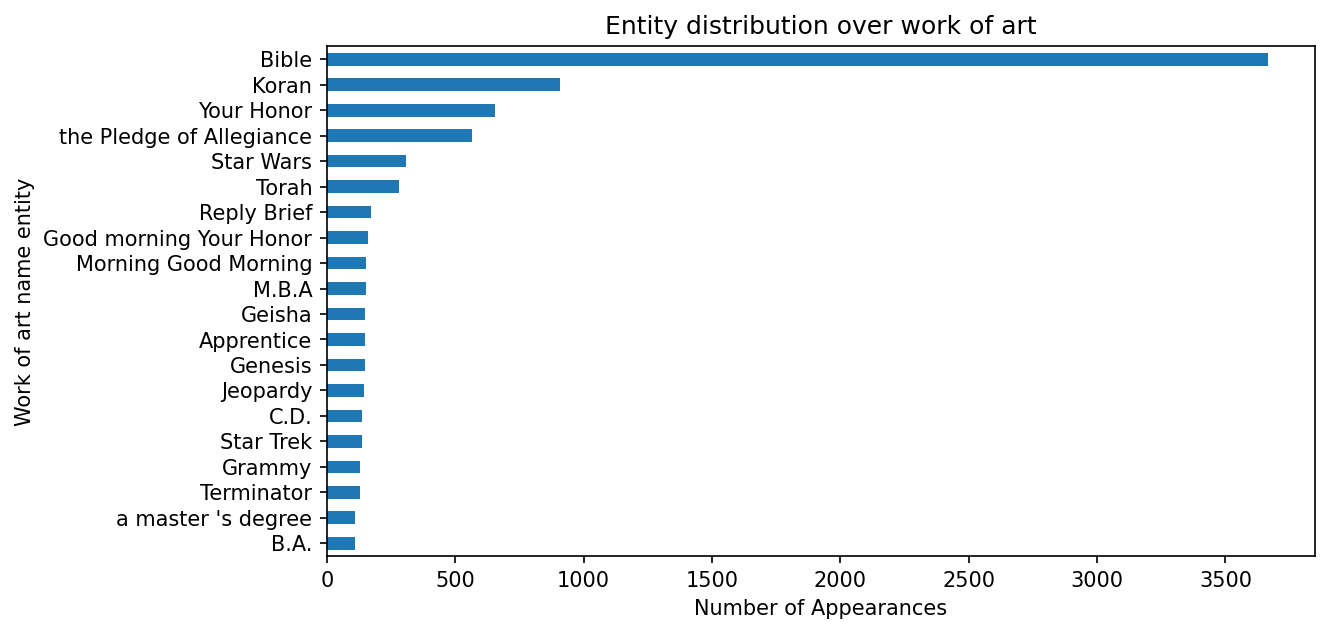

In [8]:
df_ = df[df.groupby('WORK_OF_ART')['WORK_OF_ART'].transform('count') > 100]
ax = df_['WORK_OF_ART'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Entity distribution over work of art',
                                            figsize=(8.5,4.5), );
ax.set_ylabel("Work of art name entity")
ax.set_xlabel("Number of Appearances");

### Event

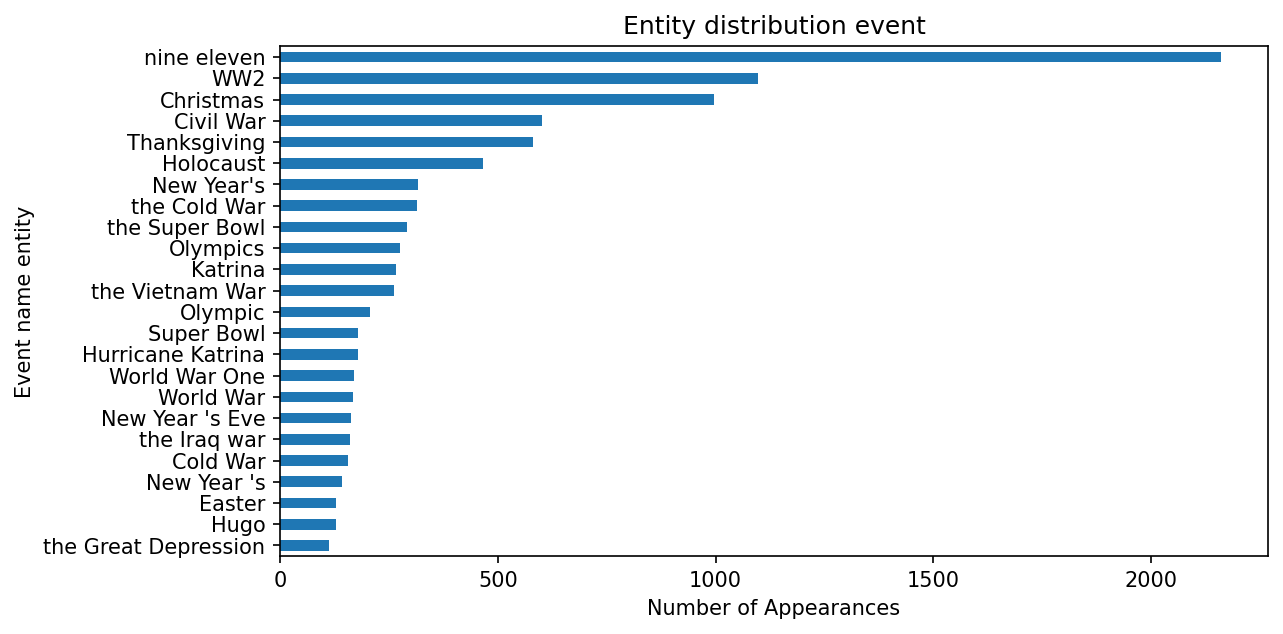

In [9]:
df['EVENT'] = np.where((df['EVENT'] == '911') | (df['EVENT'] == 'September eleventh'),
                     'nine eleven', df['EVENT'])
df['EVENT'] = np.where((df['EVENT'] == 'World War two') | (df['EVENT'] == 'World War 2'),
                     'WW2', df['EVENT'])
df['EVENT'] = np.where((df['EVENT'] == 'the Civil War'),
                     'Civil War', df['EVENT'])
df['EVENT'] = np.where((df['EVENT'] == "New Year's Eve") | (df['EVENT'] == "New Year") | (df['EVENT'] == "the New Year"),
                     "New Year's", df['EVENT'])
df_ = df[df.groupby('EVENT')['EVENT'].transform('count') > 100]
ax = df_['EVENT'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Entity distribution event',
                                            figsize=(8.5,4.5), );
ax.set_ylabel("Event name entity")
ax.set_xlabel("Number of Appearances");